In [1]:
import mitsuba as mi 
from matplotlib import pyplot as plt
mi.set_variant("cuda_ad_rgb")
import drjit as dr
from PDE3D.BoundaryShape import *
from PDE3D import PATH
from PDE3D.utils import *
from PDE3D.Solver import *

In [2]:
vis_conf = 0
spp = 512
radius = 1
slice_offset = .2
slice_axis = "z"
boundary_value = 0
resolution = [256, 256]
majorant = 100

img = np.array([[[1,2,3,4],
                 [1,2,3,4],
                 [1,2,3,4],
                 [1,2,3,4]],
                 [[1,2,3,4],
                 [1,2,3,4],
                 [1,2,3,4],
                 [1,20,3,4]],
                 [[1,2,3,4],
                 [1,2,30,4],
                 [1,20,20,20],
                 [1,2,3,4]],
                 [[1,2,3,4],
                 [1,2,12,4],
                 [1,2,30,40],
                 [1,2,3,4]]])

def boundary_generator(points, params):
    return 10 * points[0]

def source_generator(points, params):
    return dr.select(dr.norm(points) < params["radius"], params["power"], 0) + 1

def screening_generator(points, params):
    return  mi.Float(1)

#def diffusion_generator(points : mi.Point3f):
#    return dr.dot(points, mi.Point3f(1,0,0)) + dr.sin(8 * points[0] * points[1] + points[2]) + dr.cos(points[0]) + 3.5
source_p = {}
source_p["radius"] = 0.5
source_p["power"] = 1
screening_p = {}


s = 1.1
bbox_tex = mi.BoundingBox3f(min = mi.Point3f(-s,-s,-s) * radius, max = mi.Point3f(s,s,s) * radius)
#res_tex = [16, 16, 16]
#points = create_bbox_points(bbox_tex, res_tex, spp = 1, centered = True)
#alpha_vals = diffusion_generator(points) 
#vol_α, _ = create_volume_from_result(alpha_vals, res_tex)

α = TextureCoefficient("tex", bbox_tex, img)
f = FunctionCoefficient("source", source_p, source_generator)
#f = ConstantCoefficient("source", 0)
σ = FunctionCoefficient("screening", screening_p, screening_generator)

b = ConstantCoefficient("dirichlet", boundary_value)
#b = FunctionCoefficient("boundary", {}, boundary_generator)

In [3]:
shape = Sphere(radius = radius, dirichlet = [b])
data_holder_ = DataHolder(shape = shape, f=f, σ=σ, α = α)

In [4]:
print(data_holder_.σ_bar)

[9.54534]


In [5]:
images = []
for i in range(10):
    majorant = data_holder_.σ_bar + 20 * i
    data_holder = DataHolder(shape, f=f, σ=σ, α=α, default_majorant=majorant)
    wos = WosVariable(data_holder)
    slice = Slice(offset = slice_offset, axis = slice_axis)

    points, film_points = slice.create_slice_points(resolution, spp)
    L, p = wos.solve(points_in= points, conf_numbers= [mi.UInt32(0), mi.UInt32(1)], split=Split.Normal)
    image, _ =create_slice_from_result(L, resolution)
    images.append(image)

0 : 33554432 -> 1624582
1 : 1624582 -> 321072
2 : 321072 -> 65370
3 : 65370 -> 13203
4 : 13203 -> 2639
5 : 2639 -> 547
6 : 547 -> 123
7 : 123 -> 22
8 : 22 -> 5
9 : 5 -> 0
0 : 33554432 -> 1328669
1 : 1328669 -> 177120
2 : 177120 -> 23739
3 : 23739 -> 3120
4 : 3120 -> 403
5 : 403 -> 49
6 : 49 -> 5
7 : 5 -> 0
0 : 33554432 -> 1247479
1 : 1247479 -> 145743
2 : 145743 -> 16777
3 : 16777 -> 1974
4 : 1974 -> 210
5 : 210 -> 19
6 : 19 -> 3
7 : 3 -> 0
0 : 33554432 -> 1209305
1 : 1209305 -> 132377
2 : 132377 -> 14538
3 : 14538 -> 1496
4 : 1496 -> 161
5 : 161 -> 19
6 : 19 -> 3
7 : 3 -> 0
0 : 33554432 -> 1184682
1 : 1184682 -> 124175
2 : 124175 -> 12847
3 : 12847 -> 1363
4 : 1363 -> 149
5 : 149 -> 18
6 : 18 -> 1
7 : 1 -> 0
0 : 33554432 -> 1169383
1 : 1169383 -> 119578
2 : 119578 -> 12218
3 : 12218 -> 1202
4 : 1202 -> 132
5 : 132 -> 10
6 : 10 -> 0
0 : 33554432 -> 1158235
1 : 1158235 -> 116547
2 : 116547 -> 11550
3 : 11550 -> 1081
4 : 1081 -> 106
5 : 106 -> 12
6 : 12 -> 0
0 : 33554432 -> 1150330
1 : 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004874..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14989333..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004874..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14002103..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004874..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.051117547..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004874..1.57

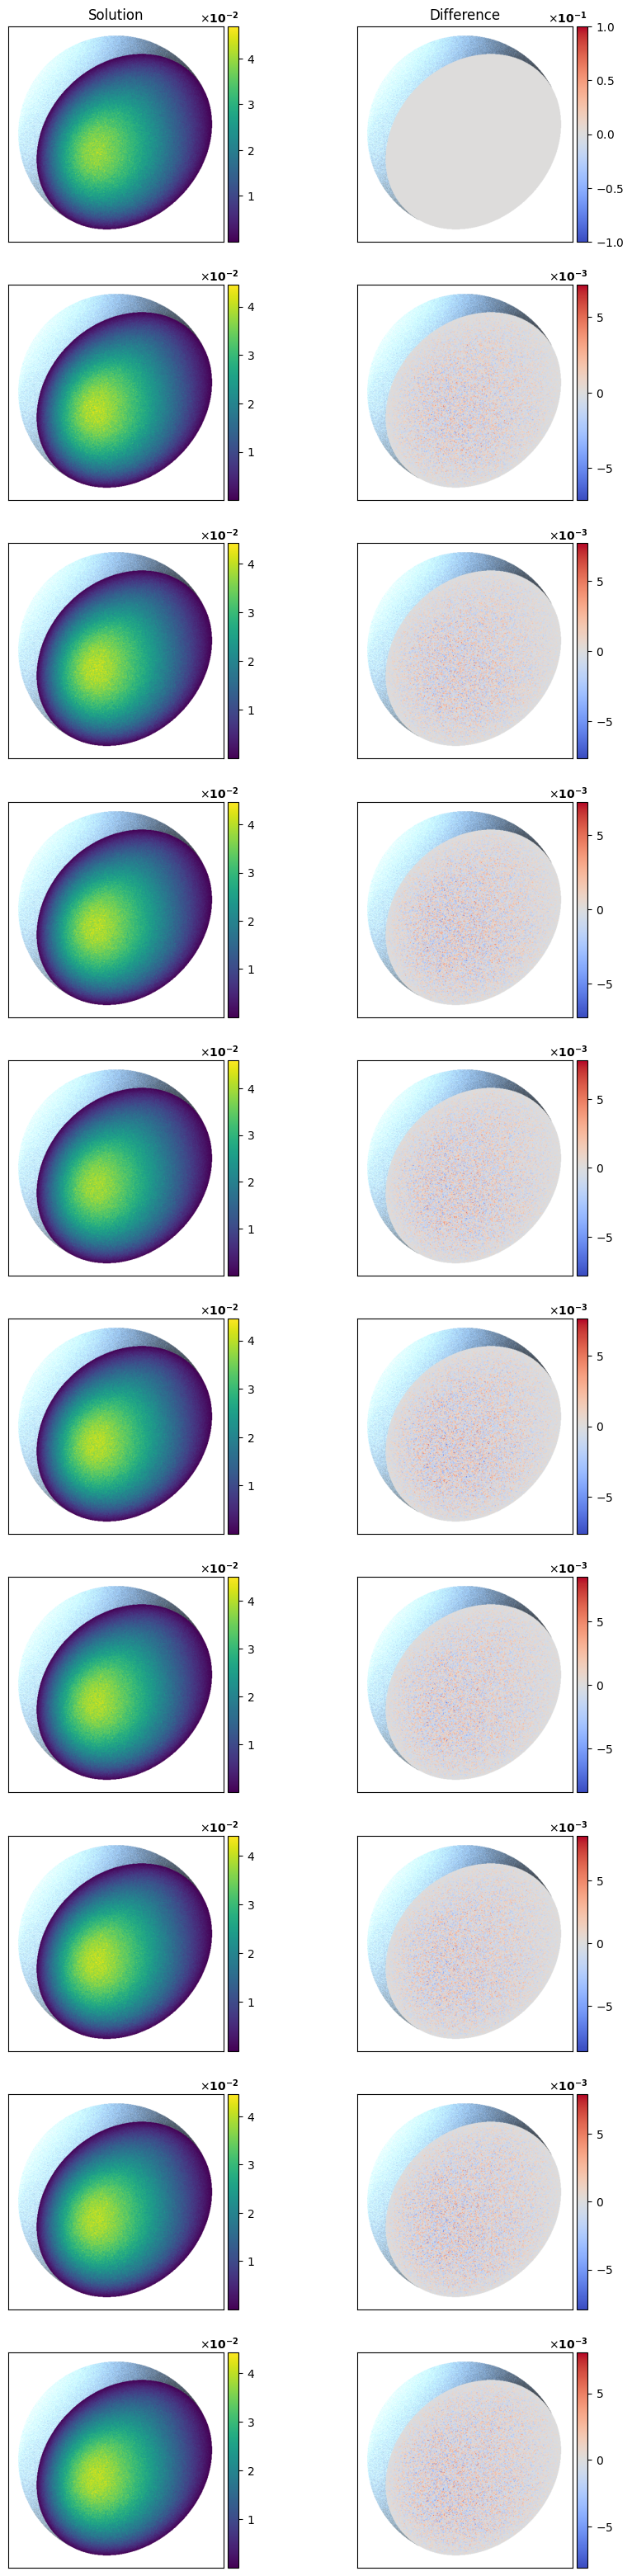

In [6]:
cam_origin = mi.Point3f([-1.0,1.0,2])
fig, ax = plt.subplots(len(images), 2, figsize = (10, len(images) * 4))
ax[0,0].set_title("Solution")
ax[0,1].set_title("Difference")
for i,image in enumerate(images):
    image_3D, norm = shape.visualize(slice = slice, slice_image = mi.TensorXf(image[vis_conf]), colormap = "viridis", cam_origin= cam_origin, image_res=[512, 512])
    diff_3D, norm_diff = shape.visualize(slice = slice, slice_image = mi.TensorXf(image[vis_conf] - images[0][vis_conf]), colormap = "coolwarm", cam_origin= cam_origin, 
                                    image_res=[512, 512], sym_colorbar=True)
    plot_image_3D(image_3D, ax[i,0], norm = norm, cmap = "viridis")
    plot_image_3D(diff_3D, ax[i,1], norm = norm_diff, cmap = "coolwarm")
    
